In [1]:
import os, sys
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from shutil import copyfile
import seaborn as sns
import json

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rcParams["figure.figsize"] = (20,3)

np.random.seed(42)
tf.random.set_seed(42)

# Below code is for enabling only particular GPU cards.
# Testing machine contained in total 6 GPUs, but for training only 5 of them were used.
# If your testing set contains less or one card, you need to change it accordingly.
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices([physical_devices[1], physical_devices[2], physical_devices[3], physical_devices[4], physical_devices[5]], 'GPU')

In [2]:
data_dir = '../data'

In [3]:
historic_data_in_minibatch = 250

In [4]:
ema_lengths = [3, 5, 8, 9, 10, 13, 20, 21, 26, 34, 50, 55, 89, 100, 144, 200, 233, historic_data_in_minibatch]
len(ema_lengths)

18

# Data loading

In [9]:
# Loading data from already prepared datasets
X_train, y_train = (
    np.load(os.path.join(data_dir, 'X_train_shuffled_with_mean_model.npz')), 
    np.load(os.path.join(data_dir, 'y_train_shuffled_with_mean_model.npz')))
X_train, y_train = X_train['arr_0'], y_train['arr_0']

X_valid, y_valid = (
    np.load(os.path.join(data_dir, 'X_valid_shuffled_with_mean_model.npz')), 
    np.load(os.path.join(data_dir, 'y_valid_shuffled_with_mean_model.npz')))
X_valid, y_valid = X_valid['arr_0'], y_valid['arr_0']

X_test, y_test = (
    np.load(os.path.join(data_dir, 'X_test_shuffled_with_mean_model.npz')), 
    np.load(os.path.join(data_dir, 'y_test_shuffled_with_mean_model.npz')))
X_test, y_test = X_test['arr_0'], y_test['arr_0']

In [10]:
X_train = X_train.reshape((X_train.shape[0]), X_train.shape[1])
X_test = X_test.reshape((X_test.shape[0]), X_test.shape[1])
X_valid = X_valid.reshape((X_valid.shape[0]), X_valid.shape[1])

## Data scaling

In [11]:
from pickle import dump

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

dump(scaler, open('input_scaler_with_ema_shuffled.pkl', 'wb'))

In [12]:
X_train = X_train.reshape((X_train.shape[0]), X_train.shape[1], 1)
X_test = X_test.reshape((X_test.shape[0]), X_test.shape[1], 1)
X_valid = X_valid.reshape((X_valid.shape[0]), X_valid.shape[1], 1)

In [14]:
features_number = X_train.shape[1]

## Split for two model inputs

In [15]:
X_train_CNN, X_train_Dense = X_train[:, :historic_data_in_minibatch, :], X_train[:, historic_data_in_minibatch:, :] 
X_test_CNN, X_test_Dense = X_test[:, :historic_data_in_minibatch, :], X_test[:, historic_data_in_minibatch:, :] 
X_valid_CNN, X_valid_Dense = X_valid[:, :historic_data_in_minibatch, :], X_valid[:, historic_data_in_minibatch:, :] 

In [18]:
len(y_train), len(y_valid), len(y_test)

(443010, 128616, 64465)

# y categorization

In [20]:
one_ids = np.where(y_train >= 0.9)
zero_ids = np.where(y_train < 0.9)

y_train[one_ids[0], one_ids[1]] = 1
y_train[zero_ids[0], zero_ids[1]] = 0

ones, zeroes = len(one_ids[0]), len(zero_ids[0])
print(f'Positive %: {ones / (ones + zeroes)}')
print(f'Negative %: {1 - (ones / (ones + zeroes))}')

y_train = y_train.astype(np.int)

Positive %: 0.04737364845037358
Negative %: 0.9526263515496264


In [21]:
one_ids = np.where(y_valid >= 0.9)
zero_ids = np.where(y_valid < 0.9)

y_valid[one_ids[0], one_ids[1]] = 1
y_valid[zero_ids[0], zero_ids[1]] = 0

ones, zeroes = len(one_ids[0]), len(zero_ids[0])
print(f'Positive %: {ones / (ones + zeroes)}')
print(f'Negative %: {1 - (ones / (ones + zeroes))}')

y_valid = y_valid.astype(np.int)

Positive %: 0.062239534739068236
Negative %: 0.9377604652609317


In [22]:
one_ids = np.where(y_test >= 0.9)
zero_ids = np.where(y_test < 0.9)

y_test[one_ids[0], one_ids[1]] = 1
y_test[zero_ids[0], zero_ids[1]] = 0

ones, zeroes = len(one_ids[0]), len(zero_ids[0])
print(f'Positive %: {ones / (ones + zeroes)}')
print(f'Negative %: {1 - (ones / (ones + zeroes))}')

y_test = y_test.astype(np.int)

Positive %: 0.05826417435817886
Negative %: 0.9417358256418211


In [23]:
y_all = np.concatenate((y_train, y_valid, y_test))
temp = np.copy(y_all)
temp.shape

one_ids = np.where(temp >= 0.9)
zero_ids = np.where(temp < 0.9)

temp[one_ids[0], one_ids[1]] = 1
temp[zero_ids[0], zero_ids[1]] = 0

ones, zeroes = len(one_ids[0]), len(zero_ids[0])
print(f'Positive %: {ones / (ones + zeroes)}')
print(f'Negative %: {1 - (ones / (ones + zeroes))}')

unique, counts = np.unique(y_all, return_counts=True)
for val, qty in zip(unique, counts):
    print(f'Label {val}: {qty}')

Positive %: 0.05148319973085612
Negative %: 0.9485168002691439
Label 0: 603343
Label 1: 32748


In [24]:
neg, pos = np.unique(y_train, return_counts=True)[1]
total = neg + pos
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

class_weight = {0: weight_for_0, 1: weight_for_1}

Weight for class 0: 0.53
Weight for class 1: 9.71


### DS Oversampling
Sample code for dataset oversampling do balance it a little bit. After the tests, in this case it didn't bring any improvement for model training, so was commented out.

In [19]:
# np.random.seed(42)

In [1]:
# bool_train_labels = np.where(y_train == 1.)[0]
# bool_train_labels.shape

In [21]:
# pos_features_CNN = X_train_CNN[bool_train_labels, :, :]
# pos_features_Dense = X_train_Dense[bool_train_labels, :, :]
# neg_features_CNN = X_train_CNN[~bool_train_labels, :, :]
# neg_features_Dense = X_train_Dense[~bool_train_labels, :, :]

# pos_labels = y_train[bool_train_labels]
# neg_labels = y_train[~bool_train_labels]

In [2]:
# ids = np.arange(len(pos_features_CNN))
# choices = np.random.choice(ids, len(neg_labels))

# res_pos_features_CNN = pos_features_CNN[choices]
# res_pos_features_Dense = pos_features_Dense[choices]
# res_pos_labels = pos_labels[choices]

# res_pos_features_CNN.shape, res_pos_features_Dense.shape

In [3]:
# resampled_features_CNN = np.concatenate([res_pos_features_CNN, neg_features_CNN], axis=0)
# resampled_features_Dense = np.concatenate([res_pos_features_Dense, neg_features_Dense], axis=0)
# resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

# order = np.arange(len(resampled_labels))
# np.random.shuffle(order)
# resampled_features_CNN = resampled_features_CNN[order]
# resampled_features_Dense = resampled_features_Dense[order]
# resampled_labels = resampled_labels[order]

# resampled_features_CNN.shape, resampled_features_Dense.shape

# Classification Model

## TensorBoard config

In [25]:
tf.keras.backend.clear_session()

In [26]:
# Training of this model was initially done from different location,
# and the actual tensorboard metrics can be found in directory `train` and `validation`
# If you want to run your own training based on this notebook,
# please create `my_dictionaries` directory on your own. 
# All TensorBoard metrics will be saved there.
root_logdir = os.path.join(os.curdir, 'my_dictionaries')

def get_run_logdir():
    import time
    run_id = time.strftime('przebieg_%Y_%m_%d-%H_%M_%S')
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [27]:
try:
    log.removeHandler(fh)
except Exception as err:
    print("Handler or log instance doesn't exists.")
else:
    print(f'Handler {fh} removed correctly. All handlers:\n{log.handlers}')

Handler or log instance doesn't exists.


In [28]:
import logging

# get TF logger
log = logging.getLogger('tensorflow')
log.setLevel(logging.DEBUG)

# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# create file handler which logs even debug messages
directory = os.path.join(run_logdir, 'tensorflow.log')
os.makedirs(run_logdir, exist_ok=True)
open(directory, 'w').close()
fh = logging.FileHandler(directory)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
log.addHandler(fh)

In [29]:
config = {
    'initial_learning_rate': 0.1,
    'decay_steps': 45,
    'decay_rate': 0.9,
    'staircase': True,
    'cnn_input_shape': [X_train_CNN.shape[1], 1],
    'kernel_initializer': 'he_normal',
    'statistical_input_shape': [X_train_Dense.shape[1], 1],
    'statistical_dense1_neurons_qty': X_train_Dense.shape[1],
    'batch_size': 7100,
}

log.info(f'Config:\n{config}')

INFO:tensorflow:Config:
{'initial_learning_rate': 0.1, 'decay_steps': 45, 'decay_rate': 0.9, 'staircase': True, 'cnn_input_shape': [250, 1], 'kernel_initializer': 'he_normal', 'statistical_input_shape': [26, 1], 'statistical_dense1_neurons_qty': 26, 'batch_size': 7100}


In [30]:
with open(os.path.join(run_logdir, 'config.json'), 'w') as config_json:
    json.dump(config, config_json)

In [31]:
# Exponential decay learning rate scheduler
initial_learning_rate = config['initial_learning_rate']
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps = config['decay_steps'],
    decay_rate = config['decay_rate'],
    staircase = config['staircase'])

In [32]:
# Callback for collecting learning rate value over the process of training
custom_lrs = []

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        custom_lrs.append({'epoch': epoch, 'lr': self.model.optimizer._decayed_lr('float32').numpy()})
        print(f"Epoch {epoch}. Current lr = {self.model.optimizer._decayed_lr('float32').numpy()}")

In [33]:
from importlib import import_module, reload
from shutil import copyfile

model_creation = import_module('model_creation_categorical_reworked')
reload(model_creation)

log.info('\n\nBuilding model:\n')
# The quantity of provided devices depends from number of GPUs in local system.
devices=["/gpu:0", "/gpu:1", "/gpu:2", "/gpu:3", "/gpu:4"]
model = model_creation.build_model(config, devices=devices, cust_lr_scheduler = lr_schedule)

copyfile('model_creation_categorical_reworked.py', os.path.join(run_logdir, 'model_creation_categorical_reworked.py'))

INFO:tensorflow:

Building model:

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replic

'./moje_dzienniki/przebieg_2021_05_29-17_08_21/model_creation_categorical_reworked.py'

## Bias correction
Initial bias correction is sometimes performed to adjust early loss value when training data on unbalanced DS. After the tests, in this case it didn't bring any improvement for model training, so was commented out.

In [4]:
# model.predict((X_train_CNN[:10], X_train_Dense[:10]))

In [5]:
# results = model.evaluate((X_train_CNN, X_train_Dense), y_train, batch_size=config['batch_size'] * len(devices))
# print("Loss: {:0.4f}".format(results[0]))

In [6]:
# initial_bias = np.log([pos/neg])
# initial_bias

In [7]:
# from importlib import import_module, reload
# from shutil import copyfile

# model_creation = import_module('model_creation_categorical')
# reload(model_creation)

# log.info('\n\nBuilding model:\n')
# devices=["/gpu:0", "/gpu:1", "/gpu:2", "/gpu:3", "/gpu:4"]
# model = model_creation.build_model(config, devices=devices, add_dropout=True, add_batch_norm=True, cust_lr_scheduler = lr_schedule, output_bias=initial_bias)

# copyfile('model_creation_categorical.py', os.path.join(run_logdir, 'model_creation_categorical.py'))

In [8]:
# pos/(total)

In [9]:
# model.predict((X_train_CNN[:10], X_train_Dense[:10]))

In [10]:
# results = model.evaluate((X_train_CNN, X_train_Dense), y_train, batch_size=config['batch_size'] * len(devices))
# print("Loss: {:0.4f}".format(results[0]))

# Model training
All training and validation metrics can be found in tensorboard folders and visualized by tensorboard.

In [34]:
log.info('\n\nModel fitting:\n\n')
history = model.fit(
    (X_train_CNN, X_train_Dense), y_train, 
    epochs=280, 
    batch_size = config['batch_size'] * len(devices), 
    validation_data=((X_valid_CNN, X_valid_Dense), y_valid), 
    verbose=0,
    class_weight=class_weight,
    callbacks=[
        tensorboard_cb, 
        CustomCallback()
    ]
)

INFO:tensorflow:

Model fitting:


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/repli

Epoch 112. Current lr = 0.003433680860325694
Epoch 113. Current lr = 0.003433680860325694
Epoch 114. Current lr = 0.0030903127044439316
Epoch 115. Current lr = 0.0030903127044439316
Epoch 116. Current lr = 0.0030903127044439316
Epoch 117. Current lr = 0.002781281480565667
Epoch 118. Current lr = 0.002781281480565667
Epoch 119. Current lr = 0.002781281480565667
Epoch 120. Current lr = 0.002781281480565667
Epoch 121. Current lr = 0.00250315316952765
Epoch 122. Current lr = 0.00250315316952765
Epoch 123. Current lr = 0.00250315316952765
Epoch 124. Current lr = 0.0022528376430273056
Epoch 125. Current lr = 0.0022528376430273056
Epoch 126. Current lr = 0.0022528376430273056
Epoch 127. Current lr = 0.0022528376430273056
Epoch 128. Current lr = 0.0020275539718568325
Epoch 129. Current lr = 0.0020275539718568325
Epoch 130. Current lr = 0.0020275539718568325
Epoch 131. Current lr = 0.0018247984116896987
Epoch 132. Current lr = 0.0018247984116896987
Epoch 133. Current lr = 0.0018247984116896987


In [35]:
model.evaluate((X_test_CNN, X_test_Dense), y_test, return_dict=True)

2015/2015 [==============================] - 19s 10ms/step - binary_accuracy: 0.9389 - tn: 60217.0000 - recall: 0.0820 - fn: 3448.0000 - tp: 308.0000 - precision: 0.3850 - loss: 0.3896 - prc: 0.0980 - fp: 492.0000 - auc: 0.5369


{'binary_accuracy': 0.9388815760612488,
 'tn': 60217.0,
 'recall': 0.08200213313102722,
 'fn': 3448.0,
 'tp': 308.0,
 'precision': 0.38499999046325684,
 'loss': 0.3896186649799347,
 'prc': 0.09803926944732666,
 'fp': 492.0,
 'auc': 0.5369489789009094}

## Learning on balanced DS
In case when DS balancing was performed

In [12]:
# resampled_steps_per_epoch = np.ceil(2.0*neg/(config['batch_size'] * len(devices)))
# resampled_steps_per_epoch

In [13]:
# log.info('\n\nModel fitting:\n\n')
# history = model.fit(
#     (resampled_features_CNN, resampled_features_Dense), resampled_labels, 
#     epochs=280, 
#     batch_size = config['batch_size'] * len(devices), 
#     steps_per_epoch=resampled_steps_per_epoch,
#     validation_data=((X_valid_CNN, X_valid_Dense), y_valid), 
#     callbacks=[
#         tensorboard_cb, 
#         CustomCallback(), 
#     ]
# )

In [14]:
# evaluate_res = model.evaluate((X_test_CNN, X_test_Dense), y_test, return_dict=True)
# evaluate_res

## Final learning rate overview during training process

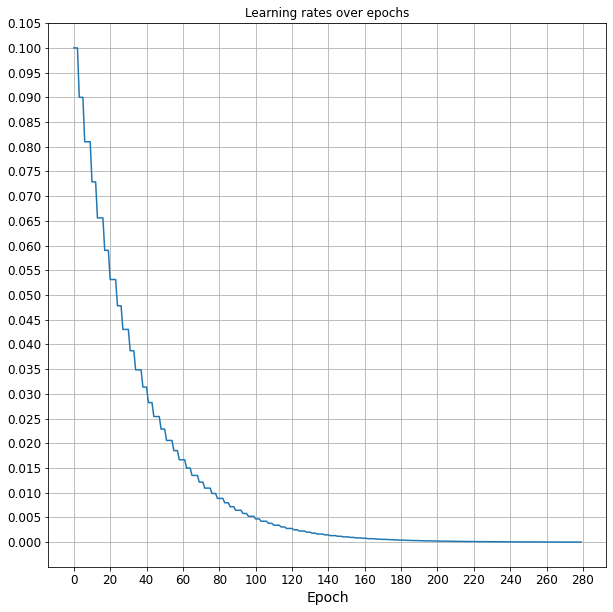

In [36]:
epochs, lrs = [], []
for entry in custom_lrs:
    epochs.append(entry['epoch'])
    lrs.append(entry['lr'])
    
plt.figure(figsize=(10, 10))
plt.plot(epochs, lrs)
plt.grid()
plt.title('Learning rates over epochs')
plt.yticks(np.arange(0.0, 0.11, 0.005))
plt.xticks(np.arange(0, 300, 20))
plt.xlabel('Epoch')
fname = os.path.join(run_logdir, 'lr.svg')
plt.savefig(fname, format='svg')
plt.show()

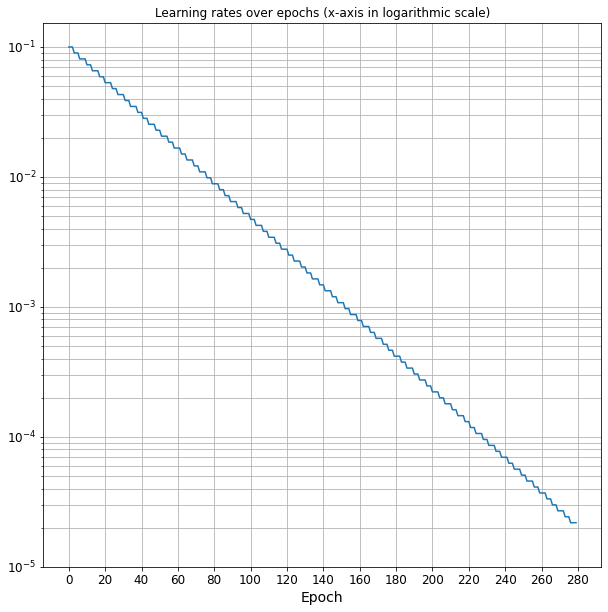

In [37]:
epochs, lrs = [], []
for entry in custom_lrs:
    epochs.append(entry['epoch'])
    lrs.append(entry['lr'])

plt.figure(figsize=(10, 10))
plt.plot(epochs, lrs)
plt.grid(which='both')
plt.yscale('log')
plt.xticks(np.arange(0, 300, 20))
plt.title('Learning rates over epochs (x-axis in logarithmic scale)')
plt.xlabel('Epoch')
plt.yticks([1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
fname = os.path.join(run_logdir, 'lr_log_scale.svg')
plt.savefig(fname, format='svg')
plt.show()

# Sample model metrics after training

In [38]:
y_pred = model.predict((X_test_CNN, X_test_Dense))
log.info(f'\n\nPredicted min, max range: {np.min(y_pred), np.max(y_pred)}\n')

INFO:tensorflow:

Predicted min, max range: (9.7275387e-20, 0.9977894)



In [43]:
# Applying treshold for classification probability
_y_pred = np.copy(y_pred)
_pred_one = np.where(_y_pred >= 0.9)
_pred_zero = np.where(_y_pred < 0.9)

_y_pred[_pred_one] = 1.0
_y_pred[_pred_zero] = 0.0

## Confusion matrixes

total: 64465
[[0.93410378 0.00763205]
 [0.05348639 0.00477779]]


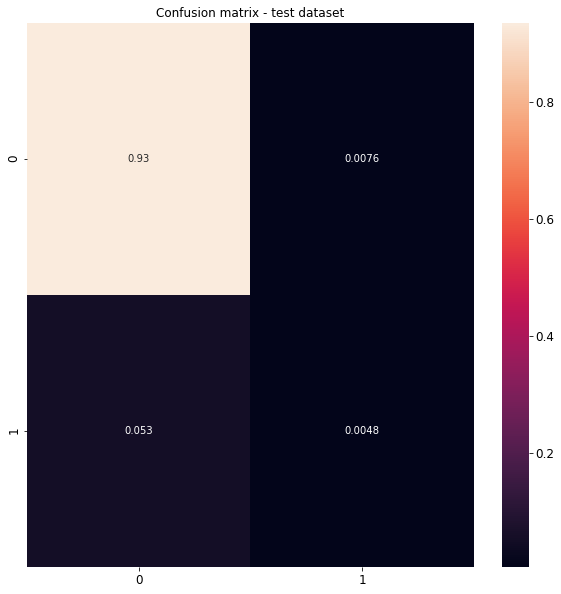

In [47]:
plt.figure(figsize=(10, 10))
cm = sklearn.metrics.confusion_matrix(y_test, _y_pred)
print(f'total: {np.sum(cm)}')
cm = cm / np.sum(cm)
print(cm)
sns.heatmap(cm, annot=True, annot_kws={'fontsize': 'xx-large'})
fname = os.path.join(run_logdir, 'confusion_matrix_test.svg')
plt.title('Confusion matrix - test dataset')
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.savefig(fname, format='svg')
plt.show()

total: 443010
[[0.94118643 0.01143992]
 [0.00540394 0.04196971]]


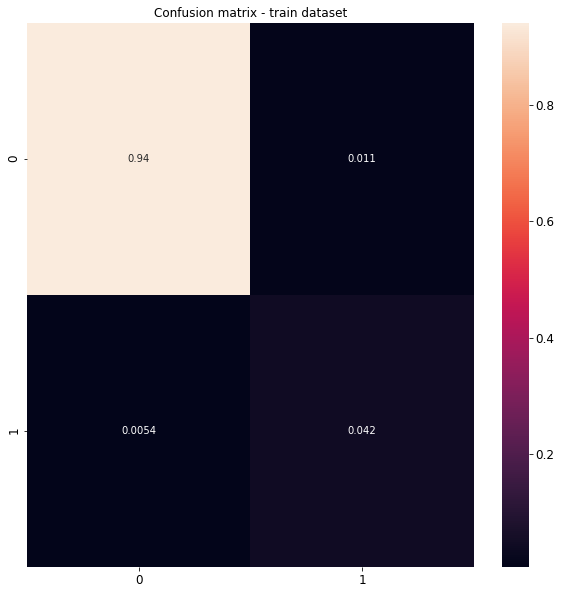

In [48]:
y_train_pred = model.predict((X_train_CNN, X_train_Dense))
_y_train_pred = np.copy(y_train_pred)
_pred_one = np.where(_y_train_pred >= 0.9)
_pred_zero = np.where(_y_train_pred < 0.9)

_y_train_pred[_pred_one] = 1.0
_y_train_pred[_pred_zero] = 0.0

plt.figure(figsize=(10, 10))
cm = sklearn.metrics.confusion_matrix(y_train, _y_train_pred)
print(f'total: {np.sum(cm)}')
cm = cm / np.sum(cm)
print(cm)
sns.heatmap(cm, annot=True, annot_kws={'fontsize': 'xx-large'})
fname = os.path.join(run_logdir, 'confusion_matrix_train.svg')
plt.title('Confusion matrix - train dataset')
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.savefig(fname, format='svg')
plt.show()

total: 128616
[[0.91416309 0.02359738]
 [0.04722585 0.01501368]]


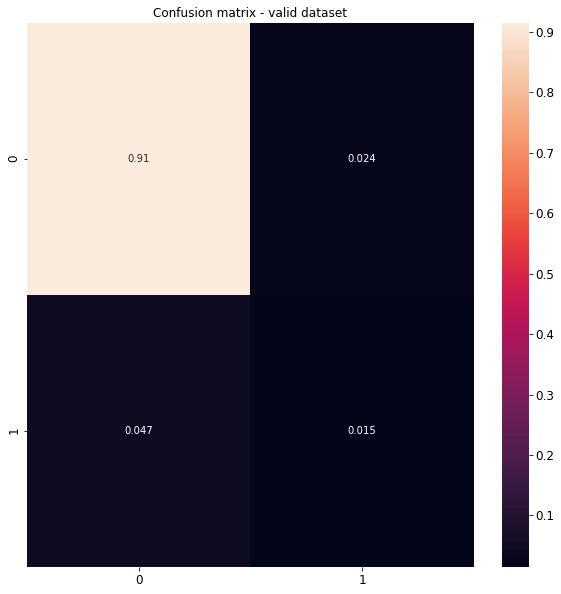

In [49]:
y_valid_pred = model.predict((X_valid_CNN, X_valid_Dense))
_y_valid_pred = np.copy(y_valid_pred)
_pred_one = np.where(_y_valid_pred >= 0.9)
_pred_zero = np.where(_y_valid_pred < 0.9)

_y_valid_pred[_pred_one] = 1.0
_y_valid_pred[_pred_zero] = 0.0

plt.figure(figsize=(10, 10))
cm = sklearn.metrics.confusion_matrix(y_valid, _y_valid_pred)
print(f'total: {np.sum(cm)}')
cm = cm / np.sum(cm)
print(cm)
sns.heatmap(cm, annot=True, annot_kws={'fontsize': 'xx-large'})
fname = os.path.join(run_logdir, 'confusion_matrix_valid.svg')
plt.title('Confusion matrix - valid dataset')
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.savefig(fname, format='svg')
plt.show()

## Classification reports

In [50]:
report = sklearn.metrics.classification_report(y_test, _y_pred)
print('Test dataset')
print(report)
with open(os.path.join(run_logdir, 'classification_report_test.txt'), 'w') as cr_file:
    cr_file.writelines(report)

Test dataset
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     60709
           1       0.39      0.08      0.14      3756

    accuracy                           0.94     64465
   macro avg       0.67      0.54      0.55     64465
weighted avg       0.91      0.94      0.92     64465



In [51]:
report = sklearn.metrics.classification_report(y_train, _y_train_pred)
print('Train dataset')
print(report)
with open(os.path.join(run_logdir, 'classification_report_test_train.txt'), 'w') as cr_file:
    cr_file.writelines(report)

Train dataset
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    422023
           1       0.79      0.89      0.83     20987

    accuracy                           0.98    443010
   macro avg       0.89      0.94      0.91    443010
weighted avg       0.98      0.98      0.98    443010



In [52]:
report = sklearn.metrics.classification_report(y_valid, _y_valid_pred)
print('Valid dataset')
print(report)
with open(os.path.join(run_logdir, 'classification_report_test_valid.txt'), 'w') as cr_file:
    cr_file.writelines(report)

Valid dataset
              precision    recall  f1-score   support

           0       0.95      0.97      0.96    120611
           1       0.39      0.24      0.30      8005

    accuracy                           0.93    128616
   macro avg       0.67      0.61      0.63    128616
weighted avg       0.92      0.93      0.92    128616



## ROC curve

In [53]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives rate (1-Specificity) [%]')
    plt.ylabel('True positives rate (Sensitivity) [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

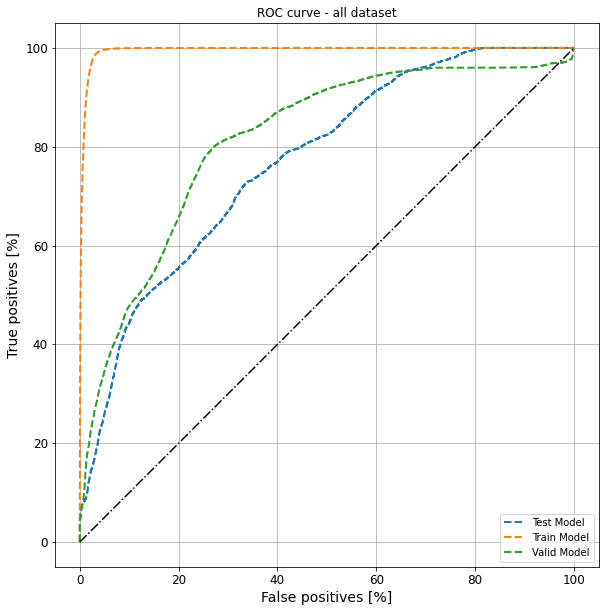

In [54]:
plt.figure(figsize=(10,10))
plot_roc("Test Model", y_test, y_pred, linestyle='--')
plot_roc("Train Model", y_train, y_train_pred, linestyle='--')
plot_roc("Valid Model", y_valid, y_valid_pred, linestyle='--')
plt.plot([0, 100], [0, 100], '-.', c='black')
plt.legend(loc='lower right')
fname = os.path.join(run_logdir, 'roc_curve_all.svg')
plt.title('ROC curve - all dataset')
plt.savefig(fname, format='svg')
plt.show()

## PRC - curve

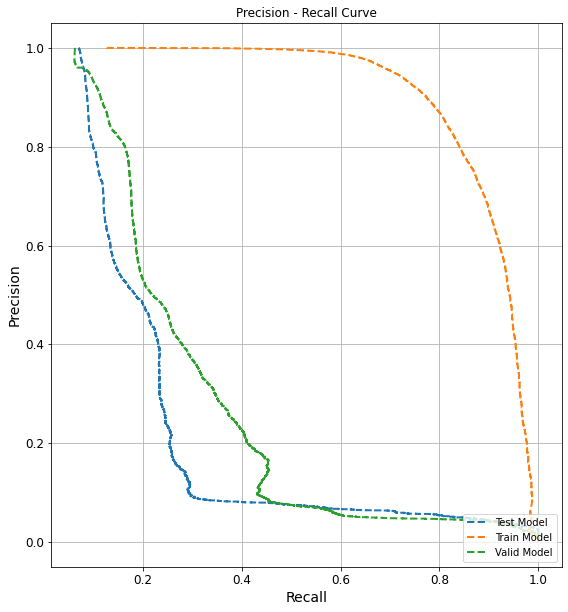

In [55]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    

plt.figure(figsize=(10,10))
plot_prc("Test Model", y_test, y_pred, linestyle='--')
plot_prc("Train Model", y_train, y_train_pred, linestyle='--')
plot_prc("Valid Model", y_valid, y_valid_pred, linestyle='--')
plt.legend(loc='lower right')
plt.title('Precision - Recall Curve')
fname = os.path.join(run_logdir, 'prc_curve.svg')
plt.savefig(fname, format='svg')
plt.show()

# Saving the model

In [100]:
experiment_run_id = run_logdir.split(sep='/')[-1]
model.save(os.path.join(run_logdir, f'trained_model-{experiment_run_id}'))
copyfile('entry_model-categorical_rework.ipynb', os.path.join(run_logdir, 'entry_model-categorical_rework.ipynb'))